In [14]:
# Imports 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting 
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

#### 1. Data Loading

In [15]:
# Load train set 
train_df = pd.read_csv('../Data/breast_cancer_trainset.csv')

print(f"Dataset shape: {train_df.shape}")
print(f"\nFirst few rows:")
train_df.head()

# Check for missing values
print("Missing values per column:")
train_df.isnull().sum()

Dataset shape: (455, 31)

First few rows:
Missing values per column:


radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64


Target variable: diagnosis
diagnosis
0    285
1    170
Name: count, dtype: int64


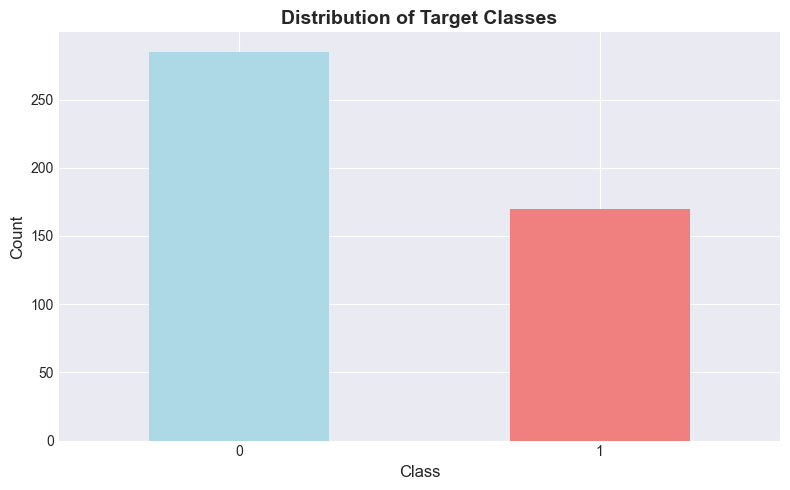

In [16]:
# Check target distribution
if 'diagnosis' in train_df.columns:
    target_col = 'diagnosis'
elif 'target' in train_df.columns:
    target_col = 'target'
else:
    target_col = train_df.columns[-1]

print(f"\nTarget variable: {target_col}")
print(train_df[target_col].value_counts())

# Visualize target distribution
plt.figure(figsize=(8, 5))
train_df[target_col].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 2. Data Preprocessing

In [17]:
# Remove ID columns and prepare features
id_cols = ['id', 'Id', 'ID', 'Unnamed: 0']
feature_cols = [col for col in train_df.columns if col not in [target_col] + id_cols]

X = train_df[feature_cols]
y = train_df[target_col]

# Encode target if categorical
if y.dtype == 'object':
    print(f"\nEncoding target: {y.unique()}")
    if set(y.unique()) == {'M', 'B'}:
        y = y.map({'M': 1, 'B': 0})
    elif set(y.unique()) == {'Malignant', 'Benign'}:
        y = y.map({'Malignant': 1, 'Benign': 0})
    print(f"Mapped to: {y.unique()}")

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(f"  Class 0 (Benign): {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.2f}%)")
print(f"  Class 1 (Malignant): {(y == 1).sum()} ({(y == 1).sum() / len(y) * 100:.2f}%)")


Features shape: (455, 30)
Target shape: (455,)

Class distribution:
  Class 0 (Benign): 285 (62.64%)
  Class 1 (Malignant): 170 (37.36%)


In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 364
Testing set size: 91


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


#### 3. Train Logistic Regression Model

In [20]:
# Train baseline model
lr_model = LogisticRegression(random_state=42, max_iter=10000)
lr_model.fit(X_train_scaled, y_train)

print("Baseline Logistic Regression model trained!")

Baseline Logistic Regression model trained!


#### 4. Hyperparameter Tuning

In [21]:
# Grid search for best parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits



Best parameters: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.9561


#### 5. Model Evaluation

In [22]:
# Make predictions
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("Training Set Evaluation:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred):.4f}")

Training Set Evaluation:
Accuracy:  0.9753
Precision: 0.9774
Recall:    0.9559
F1-Score:  0.9665
